#Projet Deep learning
Dans cette partie on apporte des amélioration sur notre modeleBaseLine




# 0-Installation des libraire et mise en palce de google drive 

In [ ]:
!pip install pyyaml h5py #pour sauvegarder le modèle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Importation des différentes librairies utiles pour le notebook
#Pour ignorer les warning.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# librairies générales
import pickle 
import pandas as pd
import numpy as np
import string
import time
import base64
import re
import sys
import copy
import random
from numpy import mean
from numpy import std
from numpy.random import randint


# librairie affichage
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from PIL import Image

#Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# TensorFlow et keras
import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical,img_to_array, load_img #from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from tqdm import tqdm
from keras.models import load_model
from keras.models import Model
from sklearn.model_selection import KFold
from keras.layers import Dense
import os  #pour accéder aux fonctionnalité systèmes
import sys 
from os import listdir
from os.path import isfile, join
import cv2  # Library to solve computer vision problems
import glob  # = global is used to return all file paths that match a specific patter


from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from tensorflow.keras.layers import Dense, BatchNormalization , Activation
from keras.models import load_model

In [2]:
# pour monter son Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/M2_ML_Projet'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/.shortcut-targets-by-id/1GUC9v3tsTllrmSXI4JPz7xIUABcps7Dj/Colab Notebooks/M2_ML_Projet


'/content/gdrive/.shortcut-targets-by-id/1GUC9v3tsTllrmSXI4JPz7xIUABcps7Dj/Colab Notebooks/M2_ML_Projet'

## Récupération des jeux de données

In [ ]:
#pour télécharger le zip file 
!wget https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip

--2022-11-07 19:58:06--  https://www.lirmm.fr/~poncelet/Ressources/Tiger-Fox-Elephant.zip
Resolving www.lirmm.fr (www.lirmm.fr)... 193.49.104.251
Connecting to www.lirmm.fr (www.lirmm.fr)|193.49.104.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7605545 (7.3M) [application/zip]
Saving to: ‘Tiger-Fox-Elephant.zip’

Tiger-Fox-Elephant. 100%[===================>]   7.25M  5.25MB/s    in 1.4s    

2022-11-07 19:58:08 (5.25 MB/s) - ‘Tiger-Fox-Elephant.zip’ saved [7605545/7605545]



In [ ]:
import zipfile
with zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref:
    zip_ref.extractall("Data_Project")

##Fonctions Utils

##Générateur

In [6]:
def create_generator(latent_dim=100):
  model = Sequential()
	# 1/4 de l'image (7x7) * nombre d'images possibles
  n_nodes = 256 * 31 * 31
  model.add(Dense(n_nodes, use_bias=False, input_dim=latent_dim))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
  model.add(Reshape((31, 31, 256)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (3,3), use_bias=False, strides=(2,2), padding='same'))
  model.add(BatchNormalization(momentum=0.8)) 		
  model.add(Activation("relu"))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (3,3), use_bias=False, strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(Conv2D(3, (3,3), use_bias=False, activation='tanh', padding='same'))
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [7]:
generator_model = create_generator()
generator_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 246016)            24601600  
                                                                 
 batch_normalization (BatchN  (None, 246016)           984064    
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 246016)            0         
                                                                 
 reshape (Reshape)           (None, 31, 31, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 62, 62, 128)      294912    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 62, 62, 128)      5

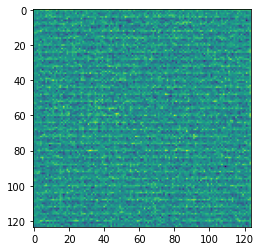

In [8]:
latent_dim=100
noise = tf.random.normal([1,latent_dim]) # (1,100)
generated_image = generator_model (noise, training=False) ##On passe le vecteur(image) à la générateur
plt.imshow(generated_image[0, :, :, 0])


##Discriminateur

In [9]:
def create_discriminator():
  model = Sequential()
  model.add(Conv2D(64, (5,5), strides=(2, 2), padding='same', input_shape=[124,124,3]))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.3))
  model.add(Conv2D(128, (5,5), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
  

In [10]:
model_discriminator=create_discriminator()
model_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 62, 62, 64)        0         
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 128)       204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 31, 31, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 31, 31, 128)       0         
                                                                 
 flatten (Flatten)           (None, 123008)           

In [11]:
discriminator_model = create_discriminator()
prediction = discriminator_model(generated_image)
print(prediction)


tf.Tensor([[0.50001115]], shape=(1, 1), dtype=float32)


In [12]:
 IMG_SIZE=124
 COLUMNS = 16
 """
 Téléchargement de jeux d'entrainement 
 @Param path_data: le chemin vers notre répertoire de données 
 @Param list_classes: la liste de nom de classe volue
 @Return training_data
 """
 
 def create_training_data(path_data, list_classes):  
  training_data=[]   #Tableau de retour 
  for classes in list_classes: # tiger et tiger_negative
      path = os.path.join(path_data, classes)
      class_num = list_classes.index(classes)
      for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
          new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
          training_data.append([new_array, class_num])  # on remplit notre tableau 
        except Exception as e:
          pass  
  return training_data   

 """
 Creation de jeux d'entrainement 
 @Param path_data: le chemin vers notre répertoire de données 
 @Param list_classes: la liste de nom de classe volue
 @Return X,y
 """ 
 def create_X_y (path_data, list_classes):
      # récupération des données
      training_data = create_training_data(path_data, list_classes)
      # tri des données
      random.shuffle(training_data)
      # création de X et y
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      X=np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE, 3)  #-1 The new shape should be compatible with the original shape.  
      y=np.array(y)
      return X,y 

 """
 Nettoyage de données : conversion en foat et normalisation 
 @Param xtrain 
 @Param xtest
 @Return xtrain_norm, xtest_norm
 """ 
 def clean_data(x): 
    # convertion d'entier en float
    xtrain_norm = x.astype('float32')
    # normalisation entre 0 et 1
    xtrain_norm = xtrain_norm / 255.0
    return xtrain_norm 

 """
 Affichage de données : 
 @Param X 
 @Param y
 """ 
 def plot_examples(X,y):
  plt.figure(figsize=(25,25))
  for i in range(10):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # cv2 lit, met les images en BGR et matplotlib lit du RGB
    #X[i] = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)
    X[i]=X[i].astype('float32')
    plt.imshow(X[i],cmap=plt.cm.binary)  
    plt.xlabel('classe ' + str(y[i]))

In [13]:
# Création d'un faux jeu de données 
# elles seront labélisées avec 0

def generate_fake_samples(nb_images):
  # generation de nombres aléatoires entre 0 et 1
  # attention ici on simplifie en mettant la taille de l'image
  # normalement il faut prendre latent_dim
  X = np.random.rand(3* 124 * 124 * nb_images)
  # reshape en images grises
  X = X.reshape((nb_images, 124, 124, 3))
  # mettre 0 comme label de classe
  y = zeros((nb_images, 1))
  return X, y  


In [14]:
##Ici on génére 10 images 
X_f,y_f= generate_fake_samples(10)

In [15]:
print(X_f.shape)
print(y_f.shape)

(10, 124, 124, 3)
(10, 1)


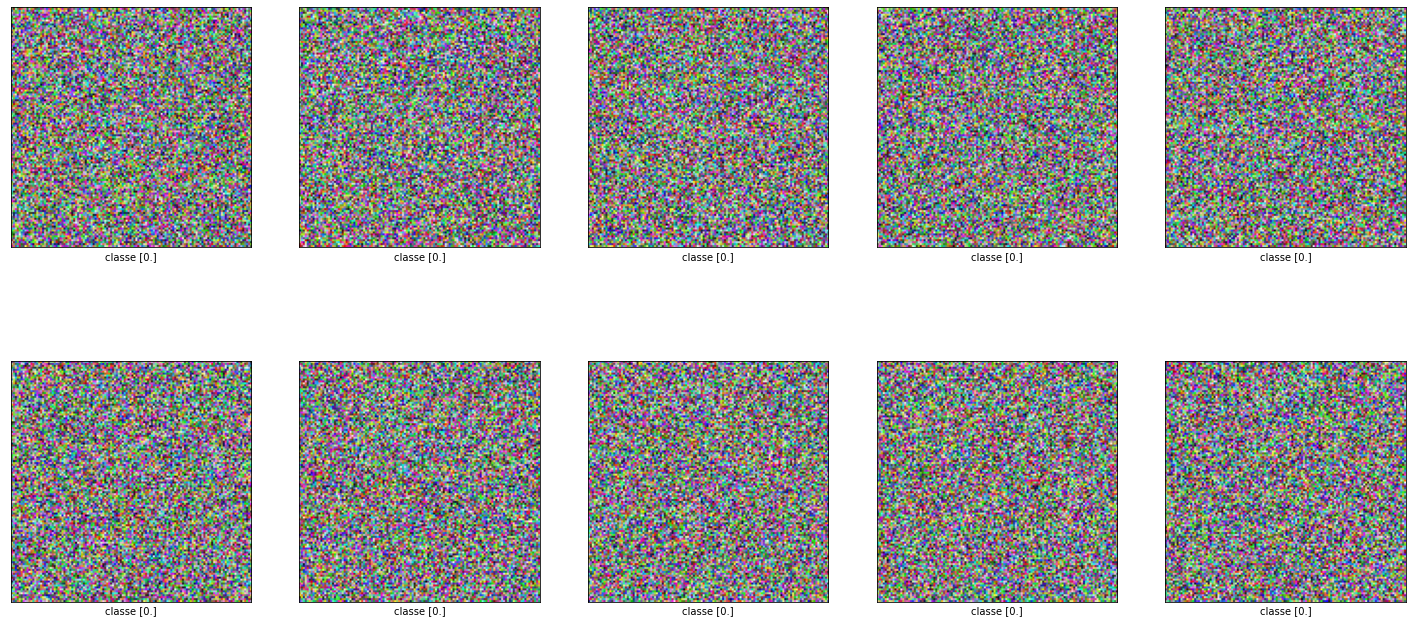

In [16]:
plot_examples(X_f, y_f)

In [17]:
# Creation d'un jeu de données de vraies images
# les vraies images sont labélisées avec 1
def generate_real_samples(dataset, nb_images):  ##pour nous 100 max
	# tirage aléatoire
	ix = randint(0, dataset.shape[0], nb_images)
	# sélection des images
	X = dataset[ix]
	# mettre 1 comme label de classe
	y = ones((nb_images, 1))
	return X, y

In [18]:
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['fox']
X, y = create_X_y(my_path, my_classes) 
X = X.astype('float32')/255.0

In [19]:
 # Normalize the images to [-1, 1]
X.shape

(100, 124, 124, 3)

In [20]:
X_r,y_r = generate_real_samples(X, 10)

In [21]:
print(X_r.shape)
print(y_r.shape)

(10, 124, 124, 3)
(10, 1)


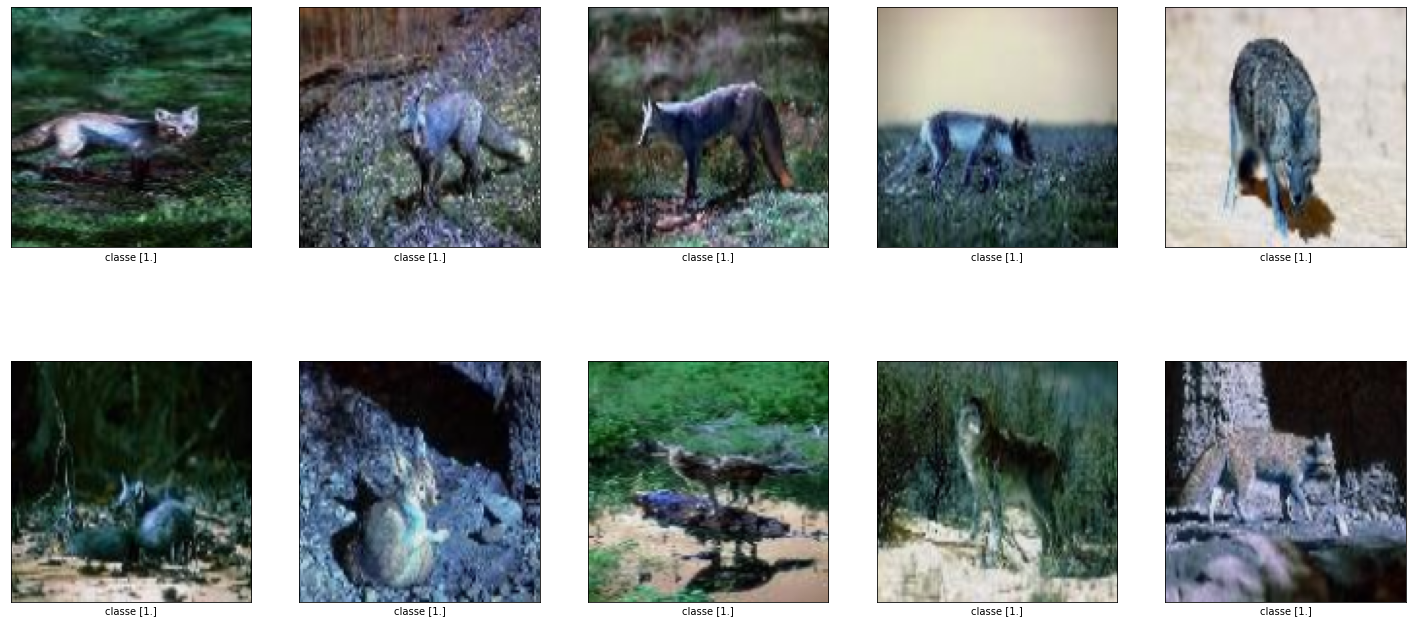

In [22]:
plot_examples(X_r, y_r)

In [23]:
# train the discriminator model
def train_discriminator(model, dataset, epochs=100, batchsize=20):
  # on constitue un jeu de données de batchsize/2 images réelles et images fausses
  half_batch = int(batchsize / 2)
  # boucler sur les epochs
  for i in range(epochs):
    # sélection d'images réelles
    X_real, y_real = generate_real_samples(dataset, half_batch) # (X, nb_image) ==>  images de tigre réel
    # mettre à jour le discriminateur avec les images réelles
    _, real_acc = model.train_on_batch(X_real, y_real)  ## il s'entraine sur les réel 

		# generation de fausses images 
    X_fake, y_fake = generate_fake_samples(half_batch) #(nb_images) ==>
		# mise à jour du discriminateur avec de fausses images 
    _, fake_acc = model.train_on_batch(X_fake, y_fake) 

		# Affichage des résultats pour l'accuracy des vraies et des fausses
    print('>%d accuracy_real=%.0f%% accuracy_fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
X.shape

(100, 124, 124, 3)

In [24]:
##a modifier
epochs= 15
# lancement de l'entrainement du discriminateur
train_discriminator(discriminator_model, X, epochs)

>1 accuracy_real=100% accuracy_fake=0%
>2 accuracy_real=100% accuracy_fake=0%
>3 accuracy_real=70% accuracy_fake=40%
>4 accuracy_real=0% accuracy_fake=80%
>5 accuracy_real=0% accuracy_fake=100%
>6 accuracy_real=0% accuracy_fake=90%
>7 accuracy_real=0% accuracy_fake=100%
>8 accuracy_real=0% accuracy_fake=100%
>9 accuracy_real=0% accuracy_fake=100%
>10 accuracy_real=0% accuracy_fake=100%
>11 accuracy_real=0% accuracy_fake=100%
>12 accuracy_real=0% accuracy_fake=100%
>13 accuracy_real=0% accuracy_fake=100%
>14 accuracy_real=10% accuracy_fake=100%
>15 accuracy_real=0% accuracy_fake=100%


Construire notre GAN

In [25]:
def create_gan(generator_model, discriminator_model):
  # mettre les poids du discriminateur non entrable
  discriminator_model.trainable = False
  # un seul modele qui regroupe 
  model = Sequential()
  # ajout du générateur
  model.add(generator_model)
  # ajout du discriminateur
  model.add(discriminator_model)

  opt = Adam(learning_rate=0.0003, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

# Le modèle GAN final ressemble à ceci :

In [26]:
#latent_dim = 100

# creation du générateur
#generator_model = create_generator(latent_dim)
# creation du discriminateur
#discriminator_model = create_discriminator()

# creation du gan
gan_model = create_gan(generator_model, discriminator_model)

gan_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 124, 124, 3)       26032512  
                                                                 
 sequential_2 (Sequential)   (None, 1)                 332801    
                                                                 
Total params: 26,365,313
Trainable params: 25,539,968
Non-trainable params: 825,345
_________________________________________________________________


In [27]:
# Généer des données, un vecteur aléatoire 
def generate_latent_points (latent_dim, nb_images): #(100, 100)
  X_input = np.random.randn(latent_dim* nb_images)
  X_input = X_input.reshape(nb_images, latent_dim)
  return X_input

In [28]:
X_input = generate_latent_points(100,100)

In [29]:
X_input.shape

(100, 100)

In [30]:
#il générer des images fausses 
#def generate_fake_samples_for_generator(generator_model, latent_dim, nb_images): #(model , 100, 100)
  # generation des points = vecteur 
 # X_input = generate_latent_points (latent_dim,nb_images)
  # prediction de la sortie du générateur
 # X = generator_model.predict(X_input)
 # X = ((X - 127.5) / 127.5 ).astype(np.uint8)
  # A ce niveau on considère que les images sont fausses
  # donc on met 0 comme label. 
 # y = zeros((nb_images, 1))
 # return X, y 

In [31]:

#il générer des images fausses 
def generate_fake_samples_for_generator(generator_model, latent_dim, nb_images): #(model , 100, 100)
  # generation des points = vecteur 
  X_input = generate_latent_points (latent_dim,nb_images)
  # prediction de la sortie du générateur
  X = generator_model.predict(X_input)
  #X = ((X - 127.5) / 127.5 ).astype(np.uint8)
  # A ce niveau on considère que les images sont fausses
  # donc on met 0 comme label. 
  y = zeros((nb_images, 1))
  return X, y   ###image générer par le générateur 

#Pour sauvgarder et afficher les images générer dont l'objectif est à partir de points latent de prédire le résultat,
def plot_and_save_generatedimages(generated_images, epoch, nb_images=10): #(image générer, 15, 10 )
	# Affichage des images
  generated_images = generated_images/2 + 0.5  # con entre 0 et 1
  plt.figure(figsize=(35,35))
  for i in range(25):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(cv2.cvtColor(generated_images[i], cv2.COLOR_BGR2RGB))#,cmap=plt.cm.binary)
	# sauvegarde de l'image
  filename = 'generated_plot_FoxCNN_withGan%03d.png' % (epoch+1)
  fileDir = 'GanImages/GanImagesElephant/'
  pyplot.savefig(fileDir+filename)
  pyplot.close()
 


def evaluate_model (dataset, epoch, generator_model, discriminator_model, latent_dim, nb_images=100, save_model=False):
  # récupération de vraies images pour le discriminateur
  X_real, y_real = generate_real_samples(dataset, nb_images)
  # Evaluation de l'accuracy pour le discriminateur
  _, acc_real = discriminator_model.evaluate(X_real, y_real, verbose=0)

  # génération de fausses images pour le générateur et donc le gan
  X_fake, y_fake = generate_fake_samples_for_generator(generator_model, latent_dim, nb_images)
  # Evaluation du discriminateur avec des fausses images
  _, acc_fake = discriminator_model.evaluate(X_fake, y_fake, verbose=0)

  print ('Accuracy réelle : %.0f%%, fausse : %.0f%%' % (acc_real*100, acc_fake*100))
  
  plot_and_save_generatedimages(X_fake, epoch)
  if save_model==True:
    # sauvegarde du generateur pour un autre usage
    filename = 'generator_model_FoxGan%03d.h5' % (epoch + 1)
    generator_model.save(filename)

In [32]:
# train the generator and discriminator
def train(generator_model, discriminator_model, gan_model, dataset, latent_dim, epochs=10, batchsize=100):
  # Pour déterminer combien il y aura de batchs analysés à chaque epoch
  batches_per_epoch = 50#int(dataset.shape[0] / batchsize) #100/5 = 20 

  # pour récupérer le même nombre d'images fausses et vraies
  half_batch = 100 #int(batchsize / 2) #20/2 =  10 

  for i in range(epochs): #pour 100 tour
    # parcours des batches pour chaque pas d'epoch
    for j in range(batches_per_epoch): # 20 tour

      #----- PARTIE DISCRIMINATOR----- r
      ##X,y = Real + fake 
      #tirage aléatoire de half_batch images vraies
      X_real, y_real = generate_real_samples(dataset, half_batch)  #( X, 10) il prends 10 images au pif 
      # generation de half_size fausses images
      X_fake, y_fake = generate_fake_samples_for_generator(generator_model, latent_dim, half_batch) #genére 10 images fake 
      # vstack permet de concaténer les vraies et fausses images dans X (resp. dans y)
      # on aurait pu utiliser np.concatenate (np.concatenate([X_real, X_fake]))
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

      # la ligne suivante permet au discriminateur de mettre à jour ses poids
      # attention dans le GAN il ne peut pas aprendre donc il ne peut le faire qu'ici
      discriminator_loss,_  = discriminator_model.train_on_batch(X, y) ##il s'entraine sur les vrai et les fausses 

      #------- PARTIE GENERATOR -------- ET DONC DE L'ENTREE DU GAN
      # Création des points comme entrée du générateur 
      # 
      X_for_gan = generate_latent_points(latent_dim, batchsize)
      # On met un 1 pour les labels des fausses images pour faire croire au discriminateur
      # qu'il s'agit de vraies images
      y_for_gan = ones((batchsize, 1)) #(10,1)

      # mise à jour des poids du générateur par propagation de l'esseur du discriminateur 
      gan_loss = gan_model.train_on_batch(X_for_gan, y_for_gan)
			# Affichage des loss
      print('epoch %d - batch %d/%d, discriminator_loss=%.3f, generator_loss=%.3f'%(i+1, j+1, batches_per_epoch, discriminator_loss, gan_loss))

    # Toutes les 20 epochs evaluation du modèle et sauvegarde du générateur
    if i==1 or i % 20==0:
        evaluate_model (dataset, i, generator_model, discriminator_model, latent_dim)
      

In [ ]:
latent_dim = 100
epochs= 2000
batchsize= 20 #10
# Creation du discriminateur
discriminator_model = create_discriminator()
# Creation du generateur
generator_model = create_generator(latent_dim)
# Creation du GAN
gan_model = create_gan(generator_model, discriminator_model)
# Chargement des données
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['fox']
X, y = create_X_y(my_path, my_classes) 
X = clean_data(X)
dataset = X

# train model
train(generator_model, discriminator_model, gan_model, dataset, latent_dim, epochs,batchsize)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
4/4 [==============================] - 0s 39ms/step
epoch 197 - batch 42/50, discriminator_loss=0.030, generator_loss=0.077
4/4 [==============================] - 0s 39ms/step
epoch 197 - batch 43/50, discriminator_loss=0.035, generator_loss=0.086
4/4 [==============================] - 0s 40ms/step
epoch 197 - batch 44/50, discriminator_loss=0.029, generator_loss=0.189
4/4 [==============================] - 0s 40ms/step
epoch 197 - batch 45/50, discriminator_loss=0.033, generator_loss=0.107
4/4 [==============================] - 0s 39ms/step
epoch 197 - batch 46/50, discriminator_loss=0.031, generator_loss=0.074
4/4 [==============================] - 0s 39ms/step
epoch 197 - batch 47/50, discriminator_loss=0.022, generator_loss=0.236
4/4 [==============================] - 0s 39ms/step
epoch 197 - batch 48/50, discriminator_loss=0.029, generator_loss=0.110
4/4 [==============================] - 0s 40ms/step
ep